['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


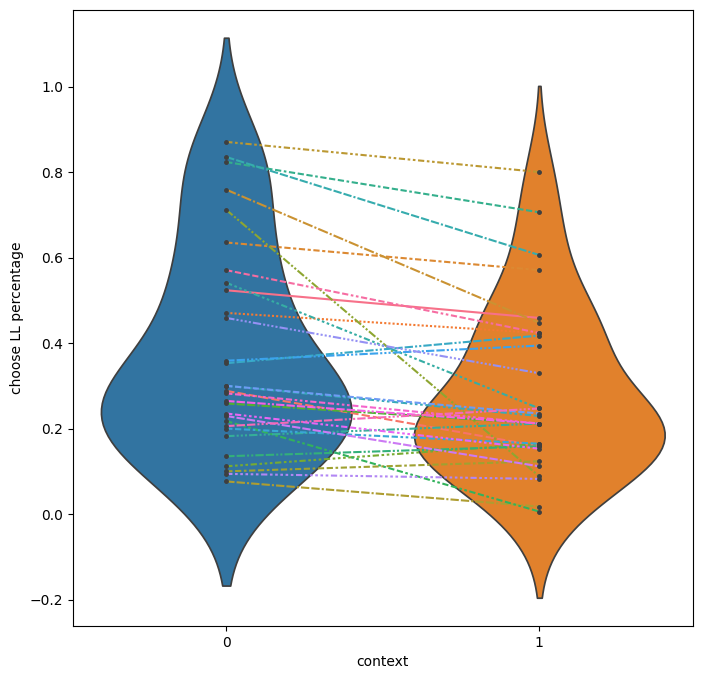

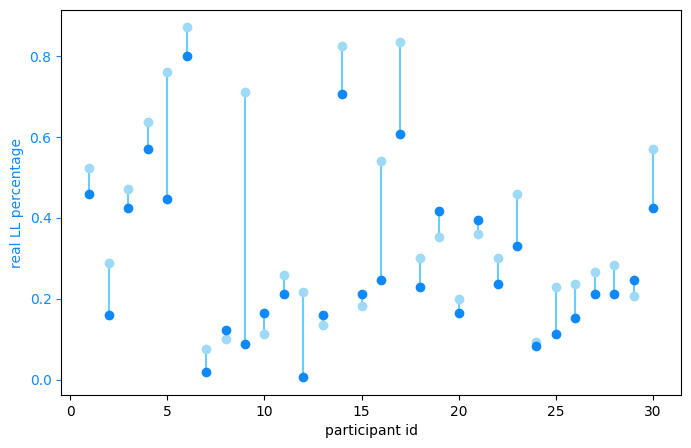

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 27 2024

@author: Yaning
"""

# get the real percentage of the participants
%run Documents/pyro_models/files_to_run/percentage_comparison.ipynb

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats 

In [2]:
# load inferred parameters
summary_dict = torch.load("Documents/pyro_models/files_to_run/results/shift_summary_0.pth")

In [3]:
summary_dict.keys()

dict_keys(['beta', 'group_beta_mean', 'group_beta_sigma', 'group_log_sigma_es_mean', 'group_log_sigma_es_sigma', 'group_log_sigma_u_mean', 'group_log_sigma_u_sigma', 'group_mean_u_mean', 'group_mean_u_sigma', 'group_shift_log_sigma_es_mean', 'group_shift_log_sigma_es_sigma', 'group_shift_log_sigma_u_mean', 'group_shift_log_sigma_u_sigma', 'group_shift_mean_u_mean', 'group_shift_mean_u_sigma', 'log_sigma_es', 'log_sigma_u', 'mean_u', 'shift_log_sigma_es', 'shift_log_sigma_u', 'shift_mean_u'])

In [4]:
# transfer the inferred parameters to cpu
pos_mean_u = np.array((summary_dict["mean_u"]["mean"]).to("cpu"))

# # this is for when make mean_u stay positive
# pos_log_mean_u = np.array((summary_dict["log_mean_u"]["mean"]).to("cpu"))

pos_log_sigma_u = np.array((summary_dict["log_sigma_u"]["mean"]).to("cpu"))
pos_log_sigma_es = np.array((summary_dict["log_sigma_es"]["mean"]).to("cpu"))
pos_beta = np.array((summary_dict["beta"]["mean"]).to("cpu"))

pos_shift_mean_u = np.array((summary_dict["shift_mean_u"]["mean"]).to("cpu"))

# # this for mean_u stay positive
# pos_shift_log_mean_u = np.array((summary_dict["shift_log_mean_u"]["mean"]).to("cpu"))

pos_shift_log_sigma_u = np.array((summary_dict["shift_log_sigma_u"]["mean"]).to("cpu"))
pos_shift_log_sigma_es = np.array((summary_dict["shift_log_sigma_es"]["mean"]).to("cpu"))

In [7]:
pos_beta.shape

(30,)

In [32]:
pos_shift_log_sigma_u

array([ 0.85789737,  0.7166632 ,  0.8777014 ,  0.8689188 ,  0.56885981,
        1.12557237,  0.85889046,  0.95278336, -0.22259842,  1.04034291,
        0.88425228,  0.01972966,  0.94828405,  0.90216899,  1.03377633,
        0.30630595,  0.64371046,  0.81291104,  0.99740389,  0.88942175,
        0.99992447,  0.83689619,  0.79926452,  0.97695448,  0.58274902,
        0.83958508,  0.88808048,  0.76283187,  1.01737409,  0.75237684])

In [20]:
# replicate the inferred parameters to 170 (trial amount)
temp = pos_mean_u + pos_shift_mean_u
mean_u_cafe = pos_mean_u
mean_u_gamble = temp
mean_u = np.concatenate((pos_mean_u, temp))
mean_u_repeat = np.tile(mean_u[:, np.newaxis], (1, 170))

# temp = pos_log_mean_u + pos_shift_log_mean_u
# mean_u_cafe = np.exp(pos_log_mean_u)
# mean_u_gamble = np.exp(temp)
# mean_u = np.concatenate((mean_u_cafe, mean_u_gamble))
# mean_u_repeat = np.tile(mean_u[:, np.newaxis], (1, 170))

temp = pos_log_sigma_u + pos_shift_log_sigma_u
sigma_u_cafe = np.exp(pos_log_sigma_u)
sigma_u_gamble = np.exp(temp)
sigma_u = np.concatenate((sigma_u_cafe, sigma_u_gamble))
sigma_u_repeat = np.tile(sigma_u[:, np.newaxis], (1, 170))

temp = pos_log_sigma_es + pos_shift_log_sigma_es
sigma_es_cafe = np.exp(pos_log_sigma_es)
sigma_es_gamble = np.exp(temp)
sigma_es = np.concatenate((sigma_es_cafe, sigma_es_gamble))
sigma_es_repeat = np.tile(sigma_es[:, np.newaxis], (1, 170))

beta = np.concatenate((pos_beta, pos_beta))
beta_repeat = np.tile(beta[:, np.newaxis], (1, 170))

In [6]:
real_data = data
real_data = real_data.reshape(60,170,8)

In [7]:
# use real data condition and the inferred parameters to get estimation values
inferred_estimation = (mean_u_repeat*real_data[:,:,2]*sigma_es_repeat**2 + 
 real_data[:,:,3]*sigma_u_repeat**2)/(real_data[:,:,2]*sigma_es_repeat**2 + sigma_u_repeat**2)

# inferred_estimation = (torch.tensor(1.)*real_data[:,:,2]*sigma_es_repeat**2 + 
#  real_data[:,:,3]*sigma_u_repeat**2)/(real_data[:,:,2]*sigma_es_repeat**2 + sigma_u_repeat**2)

# change everything to tensor
real_data = torch.tensor(real_data)
inferred_estimation = torch.tensor(inferred_estimation)
beta = torch.tensor(beta_repeat)

# create softmax and the bernoulli distribution
softmax_args = torch.stack([beta*inferred_estimation, beta*real_data[:,:,1]])
p = torch.softmax(softmax_args, dim = 0)[0]
inferred_response_distr = Bernoulli(probs=p)

In [8]:
# get one possible predict actions
inferred_response = inferred_response_distr.sample()

In [9]:
# reshape to with contexts for plotting
reshaped_inferred_response = inferred_response.reshape(2,30,170)

Check the graph fitting.

In [10]:
# calculate the predicted LL choosing percentage
inferred_percentages = []
for i in reshaped_inferred_response:
    temp = []
    for j in i:
        temp.append(len(list(filter(lambda x: (x == 1), j))
                ) / len(j))
    inferred_percentages.append(temp)

In [11]:
inferred_percentages = np.array(inferred_percentages)

In [12]:
# separate to pairs so can make line plot
infer_line = []
for i,j in zip(inferred_percentages[0], inferred_percentages[1]):
    infer_line.append([i,j])

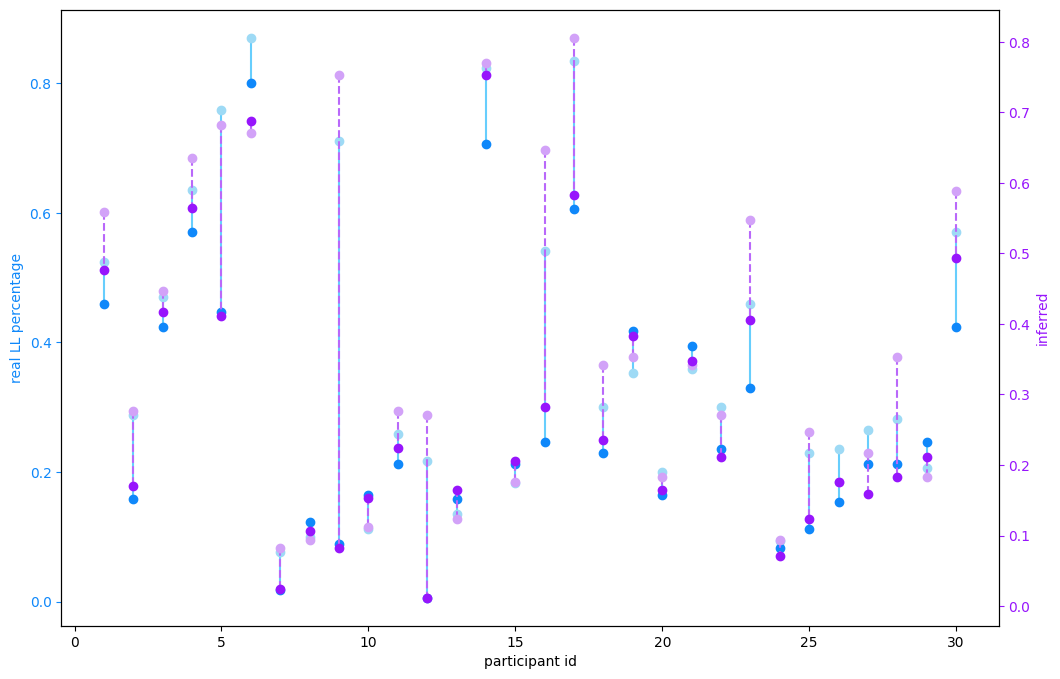

In [13]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

# inferred percentages (purple)
for i in range(len(infer_line)):
    x = [i+1, i+1]
    y_inferred = [infer_line[i][0], infer_line[i][1]]
    axes[1].plot(x, y_inferred, color="#b968fa", ls = "--")
    axes[1].plot(i+1, y_inferred[0], color = "#d2a2f8", marker = "o")
    axes[1].plot(i+1, y_inferred[1], color = "#9715fc", marker = "o")
axes[1].set_ylabel("inferred", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")



plt.show()

Check the correctly predicted percentage.

In [14]:
# create only one dimension array
# get how many are correctly predicted
real_response = real_data[:,:,4].view(-1)
num = 0
for i in range(len(real_response)):
    if inferred_response.view(-1)[i] == real_response[i]:
        num = num + 1

In [15]:
num/len(real_response)

0.8501960784313726

Plot the parameters with the real LL choosing percentage.

In [25]:
np.corrcoef(sigma_u_cafe, sigma_es_cafe)

array([[ 1.        , -0.94750654],
       [-0.94750654,  1.        ]])

In [22]:
np.corrcoef(sigma_u_gamble, mean_u_gamble)

array([[1.        , 0.58529677],
       [0.58529677, 1.        ]])

In [27]:
np.corrcoef(pos_shift_log_sigma_u, pos_shift_log_sigma_es)

array([[ 1.      , -0.999791],
       [-0.999791,  1.      ]])

In [33]:
# plot_pos_param = pos_sigma_es.reshape(2,30) - pos_sigma_u.reshape(2,30)
plot_param = sigma_es.reshape(2,30)

In [34]:
# separate to pairs so can make line plot
param_line = []
for i,j in zip(plot_param[0], plot_param[1]):
    param_line.append([i,j])

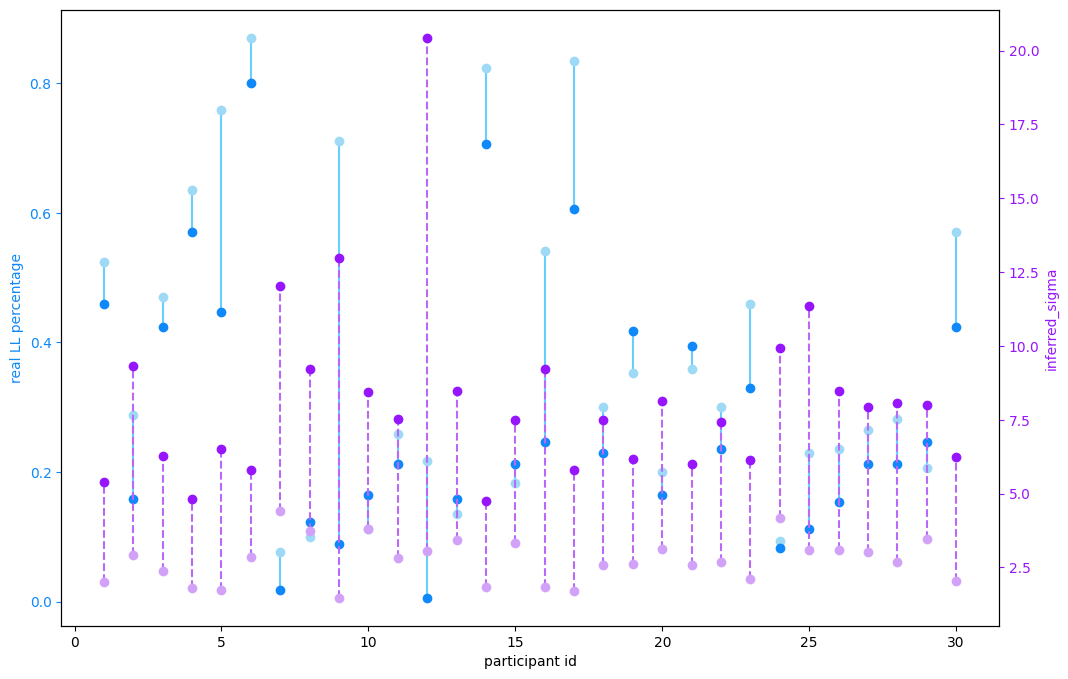

In [35]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

# inferred percentages (purple)
for i in range(len(param_line)):
    x = [i+1, i+1]
    y_inferred = [param_line[i][0], param_line[i][1]]
    axes[1].plot(x, y_inferred, color="#b968fa", ls = "--")
    axes[1].plot(i+1, y_inferred[0], color = "#d2a2f8", marker = "o")
    axes[1].plot(i+1, y_inferred[1], color = "#9715fc", marker = "o")
axes[1].set_ylabel("inferred_sigma", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")



plt.show()

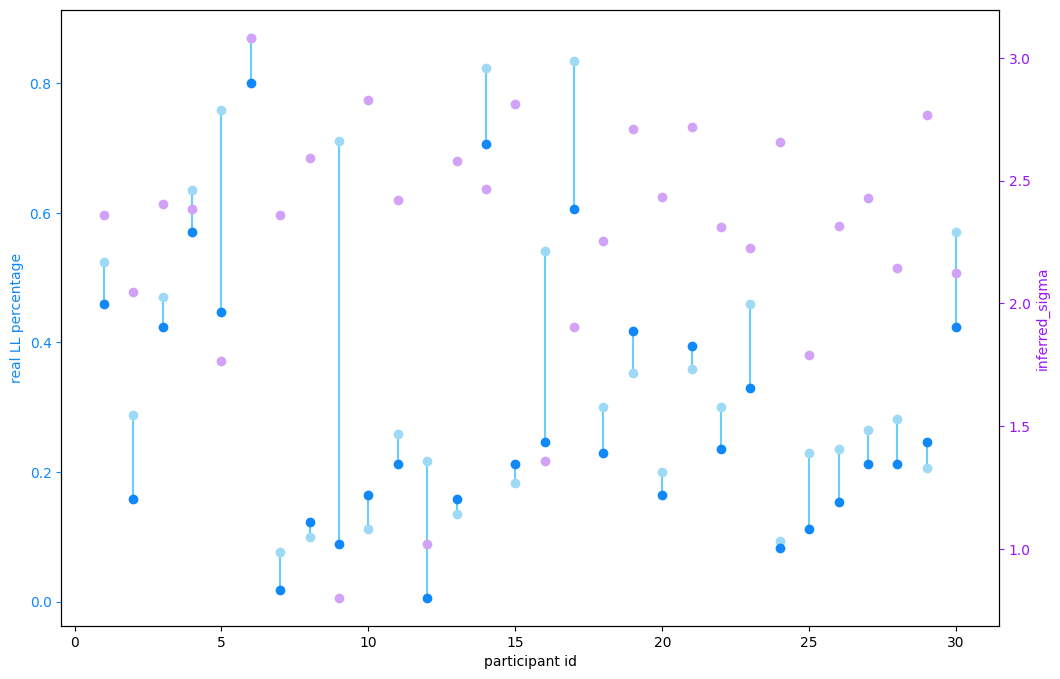

In [43]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

params = np.exp(pos_shift_log_sigma_u)
# inferred percentages (purple)
for i in range(len(params)):
    x = i+1
    y_inferred = params[i]
    axes[1].plot(x, y_inferred, color = "#d2a2f8", marker = "o")
axes[1].set_ylabel("inferred_sigma", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")


plt.show()

In [39]:
gaps = real_percentages[0] - real_percentages[1]

In [42]:
np.corrcoef(gaps, pos_shift_log_sigma_es)

array([[1.        , 0.87599904],
       [0.87599904, 1.        ]])

In [46]:
np.corrcoef(pos_shift_log_sigma_u, pos_shift_log_sigma_es)

array([[ 1.      , -0.999791],
       [-0.999791,  1.      ]])

NameError: name 'pos_shift_beta' is not defined